* [Отчет](https://disk.yandex.ru/i/9fbBGSOg9fNrOQ)
* [Дашборд](https://public.tableau.com/views/YP_final/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

# Анализ поведения пользователей в мобильном приложении
Мы работаем в компании "Ненужные вещи", доска объявлений, на которой пользователи продают свои вещи. Для доступа к площадке используется мобильное приложение. 

# Описание данных:

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в *mobile_sources.csv*: 

- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в *mobile_dataset.csv*:

- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1`—`search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.


**Наша задача:**
1. Одни пользователи совершают действия `tips_show` и `tips_click`, другие — только `tips_show`. Наша гипотеза: конверсия в просмотры контактов различается у этих двух групп.
2. Пользователи различаются по точке входа в приложение. Наша гипотеза: конверсия в целевое действие различается у групп из разных источников.

# Ход исследования
Наше исследование будет состоять из следующих этапов:
1. Обзор и предобработка данных:
    - импортирование библиотек
    - чтение данных
    - предобработка данных
2. Исследовательский анализ данных:
    - определение первых действий пользователей в приложении
    - расчет DAU/WAU
    - добавление параметра использования доп.функций
3. Проверка статистических гипотезз
    - разделение пользователей на две группы по использованию `tips_click`
    - посчитаем конверсию каждой группы
    - проверим статистически равны ли наши группы
    - разделение пользователей по группам по типу источника установки
    - расчет конверсии каждой группы
    - проверим статистически равны ли наши группы
4. Выводы
    - ответ на вопрос на сколько наши гипотезы подверждаются
    - рекомендации для отдела маркетинга по каналам установки приложений
    - рекомандации для продуктовой команды, как рекомендации влияют на конверсию
5. Создание дашборда
    - Постройте диаграмму, отображающую количество событий по дням
    - Постройте гистограмму, отображающую количество пользователей, пришедших из разных источников
    - Добавьте фильтр дашборда по типу события
6. Подготовка презентации

## Обзор и предобработка данных
### Библиотеки

In [1]:
import pandas as pd
from datetime import datetime, date
from matplotlib import pyplot as plt
import math as mth
import numpy as np
from scipy import stats as st
import warnings
import plotly.express as px 
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

### Считываем данные

In [2]:
df = pd.read_csv('mobile_dataset.csv')
df.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [3]:
soures = pd.read_csv('mobile_soures.csv')
soures.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [5]:
soures.info()
soures.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


**Вывод**

Пропусков нет, надо только поправить название столбцов и типы данных

### Предобработка данных

Переименуем все стобцы

In [6]:
df = df.rename(columns={"event.time": "event_time", "event.name": "event_name",'user.id':'user_id'})
soures = soures.rename(columns={'userId':'user_id'})

In [7]:
df_all = df.merge(soures, how='left', on='user_id')
df_all.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


Приводим столбец с датой к типу datetime и изменим тип данных на категорию

In [8]:
df_all['event_time'] = pd.to_datetime(df_all['event_time'])
df_all[['event_name', 'source']] = df_all[['event_name', 'source']].astype('category')
df_all.dtypes

event_time    datetime64[ns]
event_name          category
user_id               object
source              category
dtype: object

Избавимся от всех возможных дубликатов

In [9]:
df_all = df_all.drop_duplicates()

Заменим неявные дубликаты в действиях

In [10]:
df_all = df_all.replace('show_contacts', 'contacts_show')
df_all = df_all.replace(['search_1','search_2','search_3','search_4','search_5','search_6','search_7'], 'search')

In [11]:
df_all['minute'] = pd.to_datetime(df_all['event_time']).dt.minute
df_all['hour'] = pd.to_datetime(df_all['event_time']).dt.hour
df_all['dt'] = pd.to_datetime(df_all['event_time']).dt.date
df_all['week'] = pd.to_datetime(df_all['event_time']).dt.week

### Вывод
Провели предобработку данных. Теперь можно приступать к анализу данных

## Исследовательский анализ данных

Посмотрим на распределение в наших данных

In [12]:
df_all.describe(include=['object', 'datetime', 'category'])

,event_time,event_name,user_id,source,dt
count,74197,74197,74197,74197,74197
unique,74197,9,4293,3,28
top,2019-10-07 00:00:00.431357,tips_show,cb36854f-570a-41f4-baa8-36680b396370,yandex,2019-10-23
freq,1,40055,478,34286,3361
first,2019-10-07 00:00:00.431357,NaN,NaN,NaN,NaN
last,2019-11-03 23:58:12.532487,NaN,NaN,NaN,NaN


Самый популярное действие это показ рекомендаций, больше половины действий. Всего 4293 уникальных пользователя. Самый популярный источник Yandex

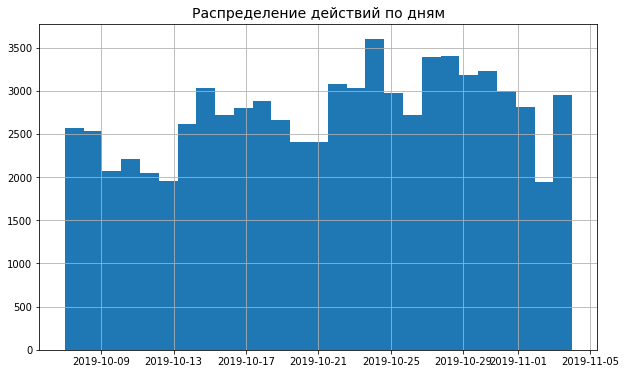

In [13]:
df_all.event_time.hist(bins=27, figsize=(10,6))
plt.title('Распределение действий по дням', size=14)
plt.show()

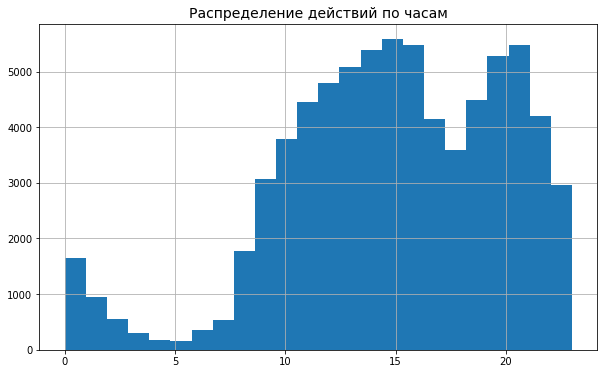

In [14]:
df_all.hour.hist(bins=24, figsize=(10,6))
plt.title('Распределение действий по часам', size=14)
plt.show()

Данные имеем распределенные, по часам наблюдаем периодичность. Два пика в 15 и 20 часов. В 5 утра у нас минимум действий

### Определяем первое действие каждого пользователя каждый день

In [15]:
first_event = df_all.groupby(['user_id'], as_index = False).agg({'event_name':'first','dt':'first','week':'first'})
first_event.rename({'dt': 'first_dt', 'event_name': 'first_event','week':'first_week'}, axis=1, inplace=True)
#сразу посмотри как распределяются первые действия
first_event.groupby(['first_event'], as_index = False).agg({'user_id':'count'}).sort_values('user_id',ascending=False)

,first_event,user_id
8,tips_show,1398
6,search,1160
4,map,807
5,photos_show,560
2,contacts_show,179
0,advert_open,127
3,favorites_add,49
7,tips_click,13
1,contacts_call,0


In [16]:
#посмотрим на все происходящие действия в нашем датайфрейме
df_all.groupby(['event_name'], as_index = False).agg({'user_id':'count'}).sort_values('user_id',ascending=False)

,event_name,user_id
8,tips_show,40055
5,photos_show,10012
6,search,6784
0,advert_open,6164
2,contacts_show,4529
4,map,3881
3,favorites_add,1417
7,tips_click,814
1,contacts_call,541


Можем предположить следующие воронки:
1. search — поиск обьявлений
2. advert_open — открытие подходящего объявления
3. contacts_show — просмотр номера владельца  
  
  
1. tips_show — показ рекомендаций
2. tips_click — клик по рекомендациям
3. contacts_show — просмотр номера владельца


Остальные действия не являются обязательными для прохождения воронки:
- photos_show — просмотр фото
- map — открыл карту объявлений
- favorites_add — добавление в избраное

- contacts_call — звонок по номеру

Их, кроме звонка, можно рассматривать с точки зрения влияния на конверсию воронки

### Расчет DAU и WAU

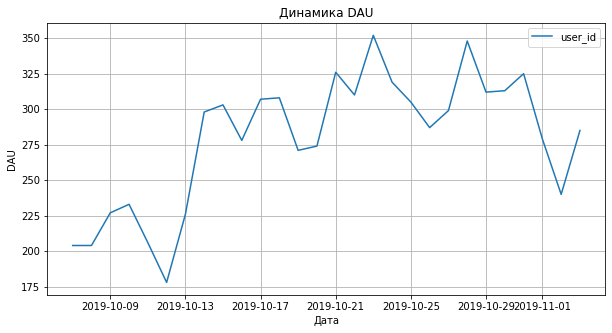

In [17]:
dau = df_all.groupby('dt').agg({'user_id':'nunique'})
dau.plot(grid=True,figsize = (10,5))
plt.ylabel('DAU')
plt.xlabel('Дата')
plt.title('Динамика DAU')
plt.show()

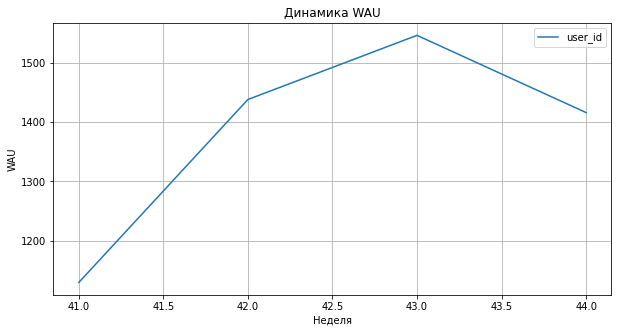

In [18]:
wau = df_all.groupby('week').agg({'user_id':'nunique'})
wau.plot(grid=True,figsize = (10,5))
plt.ylabel('WAU')
plt.xlabel('Неделя')
plt.title('Динамика WAU')
plt.show()

In [19]:
display('Средний DAU: {:.0f}'.format(dau['user_id'].mean()))
display('Средний WAU: {:.0f}'.format(wau['user_id'].mean()))

'Средний DAU: 279'

'Средний WAU: 1382'

### Добавление параметра использования дополнительных действий

Добавим столбцы, которые будут показывать совершил или нет пользователь дополнительное действие

In [20]:
cta_boosters = ['photos_show','map','favorites_add','tips_show','tips_click']
for booster in cta_boosters:
    #создаем пустой список
    group_0_users = []
    #цикл, мы добавляем в список id, которые совершили определенное дополнительное действие
    for i in range(len(df_all)):
        if df_all['event_name'][i] == booster:
            group_0_users.append(df_all['user_id'][i])
    #создаем пустой дополнительный столбец из нулей
    df_all[booster] = df.apply(lambda _: 0, axis=1)
    #у пользователей, которые совершали дополнительные действия ставим единицу, вместо нуля
    for i in range(len(df_all)):
        if df_all['user_id'][i] in group_0_users:
            df_all[booster][i] = 1

Для просмотра и клика по рекомендациям. 1 только просмотр. 2 просмотр и клик

In [21]:
#создаем пустой список
group_0_users = []
#цикл, мы добавляем в список id, которые совершили определенное дополнительное действие
for i in range(len(df_all)):
    if df_all['event_name'][i] == 'tips_show':
        group_0_users.append(df_all['user_id'][i])
#создаем пустой дополнительный столбец из нулей
df_all['tips'] = df.apply(lambda _: 0, axis=1)
#у пользователей, которые совершали дополнительные действия ставим единицу, вместо нуля
for i in range(len(df_all)):
    if df_all['user_id'][i] in group_0_users:
        df_all['tips'][i] = 1
#создаем пустой список
group_0_users = []
#цикл, мы добавляем в список id, которые совершили определенное дополнительное действие
for i in range(len(df_all)):
    if df_all['event_name'][i] == 'tips_click':
        group_0_users.append(df_all['user_id'][i])
#у пользователей, которые совершали дополнительные действия ставим двойку, вместо единицы
for i in range(len(df_all)):
    if df_all['user_id'][i] in group_0_users:
        df_all['tips'][i] = 2        

In [22]:
df_all.head()

,event_time,event_name,user_id,source,minute,hour,dt,week,photos_show,map,favorites_add,tips_show,tips_click,tips
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0,2019-10-07,41,0,1,0,1,0,1
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0,2019-10-07,41,0,1,0,1,0,1
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0,0,2019-10-07,41,0,1,0,1,1,2
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0,2019-10-07,41,0,1,0,1,0,1
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0,0,2019-10-07,41,0,1,0,1,1,2


### Расчет Retention Rate

In [23]:
df_all = df_all.merge(first_event, on='user_id', how='left')
df_all['lifetime'] = (
    df_all['week'] - df_all['first_week']
)
df_all.head()

,event_time,event_name,user_id,source,minute,hour,dt,week,photos_show,map,favorites_add,tips_show,tips_click,tips,first_event,first_dt,first_week,lifetime
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0,2019-10-07,41,0,1,0,1,0,1,advert_open,2019-10-07,41,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0,2019-10-07,41,0,1,0,1,0,1,advert_open,2019-10-07,41,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0,2019-10-07,41,0,1,0,1,0,1,advert_open,2019-10-07,41,0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0


In [24]:
# строим таблицу удержания
df_grouped = df_all.pivot_table(
    index=['first_week'], columns='lifetime', values='user_id', aggfunc='nunique'
)
df_grouped
# вычисляем размеры когорт
cohort_sizes = (
    df_all.groupby('first_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
# объединяем размеры когорт и таблицу удержания
df_grouped = cohort_sizes.merge(
    df_grouped, on='first_week', how='left'
).fillna(0)
df_grouped = df_grouped.div(
    df_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

df_grouped

,0,1,2,3
first_week,,,,
41,1.0,0.240708,0.150442,0.10531
42,1.0,0.241852,0.132933,0.00000
43,1.0,0.218464,0.000000,0.00000
44,1.0,0.000000,0.000000,0.00000


### Поиск действий, которые совершаются вместе с целевым событием
Для этого отберем только тех пользователей, которые хотя бы раз совершили целевое действие

In [25]:
contacts_show = df_all.query('event_name == "contacts_show"')
contacts_show_user = df_all[df_all.user_id.isin(contacts_show.user_id.unique())]
contacts_show_user.head()

,event_time,event_name,user_id,source,minute,hour,dt,week,photos_show,map,favorites_add,tips_show,tips_click,tips,first_event,first_dt,first_week,lifetime
12,2019-10-07 00:02:07.374346,tips_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0
24,2019-10-07 00:05:16.003328,contacts_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,5,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0
28,2019-10-07 00:06:01.349291,tips_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,6,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0
32,2019-10-07 00:06:56.367054,tips_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,6,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0
35,2019-10-07 00:09:24.585200,tips_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,9,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0


Отберем только целевые действия

In [26]:
contacts_show = contacts_show_user.query('event_name == "contacts_show"').copy(deep=True)
contacts_show.head()

,event_time,event_name,user_id,source,minute,hour,dt,week,photos_show,map,favorites_add,tips_show,tips_click,tips,first_event,first_dt,first_week,lifetime
24,2019-10-07 00:05:16.003328,contacts_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,5,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0
70,2019-10-07 00:18:53.427525,contacts_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,18,0,2019-10-07,41,0,1,0,1,1,2,tips_show,2019-10-07,41,0
195,2019-10-07 08:11:07.995945,contacts_show,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex,11,8,2019-10-07,41,1,0,0,0,0,0,photos_show,2019-10-07,41,0
244,2019-10-07 09:33:19.822541,contacts_show,9dfa242e-8630-480a-806b-5736bcda8f3d,google,33,9,2019-10-07,41,0,0,0,1,0,1,contacts_show,2019-10-07,41,0
327,2019-10-07 10:19:49.080484,contacts_show,1a3361d1-2002-4389-a669-ecb06ea7a90a,yandex,19,10,2019-10-07,41,0,0,0,1,0,1,tips_show,2019-10-07,41,0


Напишем функцию определения предыдушего параметра предыдущего действия до целевого. Отбираем по user_id и времени события

In [27]:
def ger_previous_parametr(user, time, row):
    df = contacts_show_user.query(f'user_id == "{user}" and event_time < "{time}"').sort_values(by='event_time', ascending=False)
    if df.size == 0:
        return 0
    return df[row].iloc[0]

применяем нашу функцию для получения предыдщуго события и времени

In [28]:
contacts_show['source_event_name'] = contacts_show.apply(lambda x: ger_previous_parametr(x['user_id'], 
                                                                                            x['event_time'],
                                                                                            'event_name'), 
                                                               axis=1)
contacts_show['source_event_name_time'] = contacts_show.apply(lambda x: ger_previous_parametr(x['user_id'],
                                                                                                        x['event_time'],
                                                                                                        'event_time'), 
                                                               axis=1)

Находим разницу между целевым событием и предыдущим

In [29]:
contacts_show = contacts_show[contacts_show['source_event_name_time'] != 0]
contacts_show['time_dif'] = contacts_show['event_time']-contacts_show['source_event_name_time']
contacts_show['time_dif'] = contacts_show['time_dif'] / np.timedelta64(1, 's')

Сгруппируем данные по событиям посмотрим медианную разницу во времени, кол-во типов событий

In [30]:
contacts_show.groupby('source_event_name').agg({'source_event_name':'count','time_dif':'median'}).sort_values('time_dif')

,source_event_name,time_dif
source_event_name,,
contacts_show,1524,37.024885
advert_open,73,42.482531
map,60,57.853637
favorites_add,44,60.258795
tips_show,1787,63.073993
photos_show,411,114.681611
search,237,145.884688
contacts_call,201,233.304669
tips_click,13,708.153106


Самым популярным действием до целевого у нас явлется просмотр фото и поиск. Время между этими действиями и целевым составляет 114 и 145 секунд соответсвенно.  
Самым быстрым событием является открытие объявления. Можно предположить, что когда пользователь открывает объявления он уже уверен и хочет найти контакт продавца. Возможно надо будет посмотреть конверсию этого события.

## Проверка статистически гипотез

### Постановка нулевой гипотезы по использованию рекомендаций

Наша нулевая гипотеза звучит так:
- конверсия в просмотры контактов между пользователями, которые совершили событие tips_show и tips_click и другими, которые совершили только tips_show, равна.

Альтернативная гипотеза звучит так:
- конверсия в просмотры контактов между пользователями, которые совершили событие tips_show и tips_click и другими, которые совершили только tips_show, не равна.

Напишем функцию для рассчет конверсии и проведения zтеста для проверки статистической значимости. 

In [31]:
def z_test(separator,group_1,group_2, alpha):
    #разбиваем наш датафрейм
    df_1 = df_all[df_all[separator] == group_1]
    df_2 = df_all[df_all[separator] == group_2]
    #для расчета конверсии возьмем всех уникальных пользователей в каждой группе
    trials = np.array([df_1['user_id'].nunique(),
                       df_2['user_id'].nunique()]
                     )

    #и возьмем уникальных пользователей, которые совершили целевое действие
    successes = np.array([df_1[df_1['event_name']=='contacts_show']['user_id'].nunique(),
                          df_2[df_2['event_name']=='contacts_show']['user_id'].nunique()]
                        )    
    p1 = successes[0]/trials[0]
    print('Конверсия выборки {} из группы {}: {:.2f}'.format(group_1,separator,p1))
    p2 = successes[1]/trials[1]
    print('Конверсия выборки {} из группы {}: {:.2f}'.format(group_2,separator,p2))
    difference = p1 - p2
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для {} и {}, p-значение: {p_value:.2f}'.format(group_1, group_2, p_value=p_value))
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [32]:
z_test('tips',1,2,0.05)

Конверсия выборки 1 из группы tips: 0.17
Конверсия выборки 2 из группы tips: 0.31
Проверка для 1 и 2, p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница


Конверсия с `tips_click` выше чем, без него. Статистический отвергаем нулевую гипотезу о равенстве конверсии. Разница в пропорциях говорит, что при данных выборках, есть статистически значимое различие.

### Постановка нулевой гипотезы по источнику

Наша нулевая гипотеза звучит так:
- конверсия в просмотры контактов между пользователями из разных источников, равна.

Альтернативная гипотеза звучит так:
- конверсия в просмотры контактов между пользователями из разных источников, не равна.

In [33]:
z_test('source','other','yandex',0.05)

Конверсия выборки other из группы source: 0.19
Конверсия выборки yandex из группы source: 0.25
Проверка для other и yandex, p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [34]:
z_test('source','other','google',0.05)

Конверсия выборки other из группы source: 0.19
Конверсия выборки google из группы source: 0.24
Проверка для other и google, p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [35]:
z_test('source','yandex','google',0.05)

Конверсия выборки yandex из группы source: 0.25
Конверсия выборки google из группы source: 0.24
Проверка для yandex и google, p-значение: 0.82
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Наибольшая конверсия у пользователей, которые пришли из Yandex. После них идут пользователи из Google и Other, соответственно. Но между собой Google и Yandex не имеют статистически значимой разницы.

### Постановка нулевой гипотезы по использованию дополнительных действий

Наша нулевая гипотеза звучит так:
- конверсия в просмотры контактов между пользователями совершающие разные дополнительные действия, равна.

Альтернативная гипотеза звучит так:
- конверсия в просмотры контактов между пользователями совершающие разные дополнительные действия, не равна.

In [36]:
for i in ['photos_show','map','favorites_add']:
    z_test(i,0,1,0.05)
    print()

Конверсия выборки 0 из группы photos_show: 0.20
Конверсия выборки 1 из группы photos_show: 0.31
Проверка для 0 и 1, p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница

Конверсия выборки 0 из группы map: 0.24
Конверсия выборки 1 из группы map: 0.20
Проверка для 0 и 1, p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница

Конверсия выборки 0 из группы favorites_add: 0.21
Конверсия выборки 1 из группы favorites_add: 0.39
Проверка для 0 и 1, p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница



- Открытие фотографий объявления увеличивает конверсию на 11%
- Открытие карт уменьшает конверсию на 4%
- Добавление увеливичает конверсию на 18%

## Вывод

Обе наши нулевые гипотезы мы отвергли и получили:
- **Конверсия у пользователей, которые переходят по рекомендованным объявлениям выше на 14%**
- **Среди источников наибольшая конверсия у пользователей, которые скачали приложение через Yandex и Google 25% и 24%, соответсвенно**

Рекомендации для отдела маркетинга:
- Предлагаю увелечить бюджеты у кампаний на скачивание из Yandex и Google. Там у нас наибольшая конверсия внутри приложения. Чтобы точно определить лучшую рекламную сетку, надо посмотреть на цену установки приложения

Рекомендации для продуктовой команды:
- Рекомендованные объявления повышают конверсию у пользователей, только если они переходят по ним.
- Надо подобрать другу модель рекомендаций, которая будет подходить большему числу пользователей и соответвенно генерировать больше переходов по ним.
- Сделать объявления с фотографиями выше в поисковой ленте
- Возможно как-то пропушить функцию избранного, многи пользователи могут про нее просто не знать
- Карты убирать не надо,не смотря на понимажение конверсии. Это убьет пользовательский опыт